In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from foodwebs.foodweb import FoodWeb
from foodwebs.foodweb_io import readFW_SCOR
import networkx as nx

import plotly.graph_objects as go
import matplotlib.pyplot as pltś
import pylab

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [6]:
import glob
food_webs = [readFW_SCOR(net_path) for net_path in glob.glob('./data/*')]

for web in food_webs:
    print(f'{web.title[:30]} --> {web.n}, {web.n_living}')
    web.nodeDF['trophic'] = round(web.nodeDF.TrophicLevel)

Upper Chesapeake Bay in Summer --> 34, 28
Albatross Bay _ 465 ,   bay/fj --> 99, 92
USA, Mid Atlantic Bight _ 99 , --> 55, 54
Flow network of St Marks febs2 --> 51, 40
Table 9. Flow data for the Thu --> 33, 29
Alaska, Prince William Sound _ --> 19, 18
"Mdloti Network, March 2003, i --> 46, 43
Bothnian Bay; Sandbert, et al. --> 12, 10
FLORIDA BAY TROPHIC EXCHANGE M --> 125, 104
Oneida Post ZM Unbalanced      --> 76, 73
Bay of Biscay _ 335 ,   contin --> 32, 30


## Foodweb's heatmap

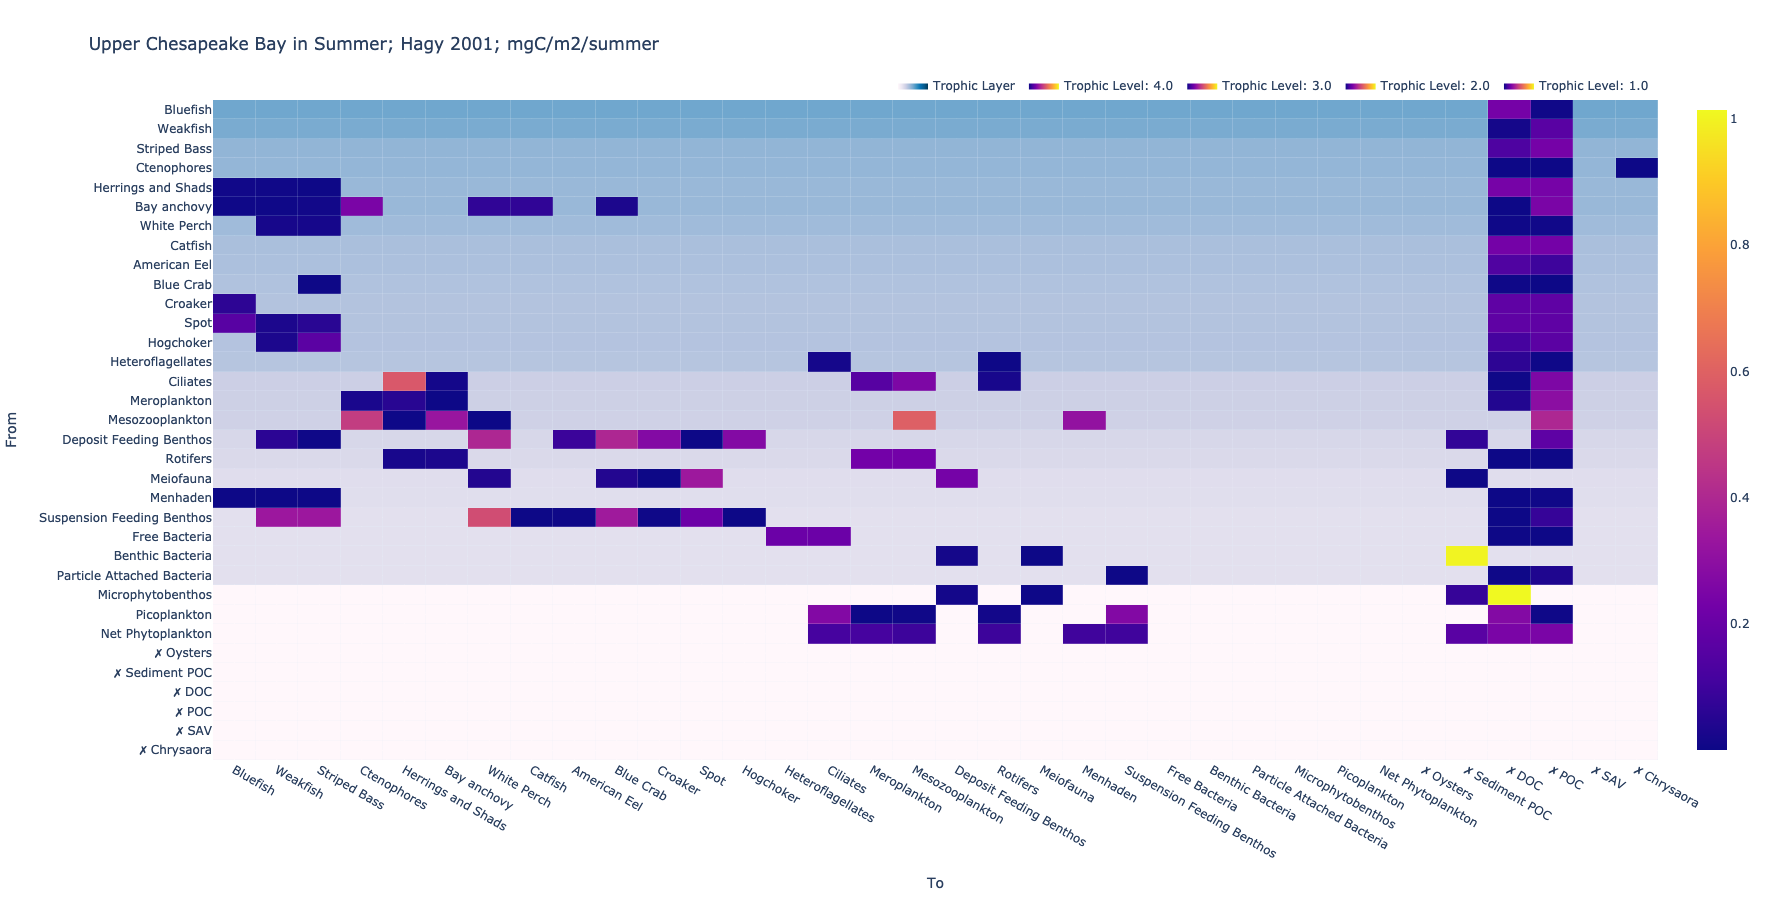

In [19]:
def get_is_alive_mapper(net):
    '''
    Creates dictionary which special X character to names, which are not alive
    '''
    return {x.Names: f'\u2717 {x.Names}' for i, x in net.nodeDF.iterrows() if not x.IsAlive}


def add_not_alive_mark(series, mapper):
    '''
    Adds special X character to each name wchich is not alive
    '''
    return [mapper.get(x, x) for x in series]


def get_trophic_heat(net):
    '''
    Creates pd.DataFrame which for each 'from' Name to 'to' Names assigns 'from' Name's trophic level
    '''
    names = net.Names.values
    return pd.DataFrame([(x, y, net[net.Names == x].TrophicLevel.values[0]) for x in names for y in names],
                        columns=['from', 'to', 'trophic'])


def prepare_data(net, normalization=None, add_external_flows=False):
    '''
    Prepares data for heatmap
    
    Parameters
    ----------
    normalization - defines how flow weights should be normalized
    
    avaiable options:
        - None
        - all - normalize by dividing by all network's flows
        - biomass - divide each weight by 'from' node's Biomass 
        - log - log of weights
        - inputs - divide each weight by sum of input weights
    
    add_external_flows : Bool - add columns for Imports, Exports, Respiration
    '''
    names_mapper = get_is_alive_mapper(net)

    node_df = net.nodeDF.reset_index(drop=True)[['Names', 'IsAlive', 'TrophicLevel', 'trophic', 'Biomass']]
    node_df['Names'] = add_not_alive_mark(node_df.Names, names_mapper)
    
    flow_cols = ['from', 'to', 'weights']
    heat_data = pd.DataFrame(net.getFlows(True), columns=flow_cols)
    heat_data['from'] = add_not_alive_mark(heat_data['from'], names_mapper)
    heat_data['to'] = add_not_alive_mark(heat_data['to'], names_mapper)
    heat_data = heat_data.merge(node_df[['Names', 'trophic', 'Biomass']], left_on='from', right_on='Names', how='left')

    if normalization == 'all':
        heat_data['weights'] = net.getNormInternFlows()
    elif normalization == 'biomass':
        heat_data['weights'] = heat_data['weights'] / heat_data['Biomass'] 
    elif normalization == 'log':
        heat_data['weights'] = np.log(heat_data['weights'])
    elif normalization == 'inputs':
        tmp_df = heat_data.merge(heat_data.groupby('to').sum().reset_index(), left_on='from', right_on='to')
        heat_data['weights'] = tmp_df.weights_x / tmp_df.weights_y
    if add_external_flows:
        external_flows = pd.DataFrame(net.getExternalFlows(), columns=flow_cols)
        external_flows['from'] = add_not_alive_mark(external_flows['from'], names_mapper)
    
        heat_data = pd.concat([heat_data, external_flows]).fillna(0)
    return node_df, heat_data

def get_trophic_heatmap(node_df):
    '''
    Creates thropic level Trace
    '''
    res_pd = get_trophic_heat(node_df)
    return go.Heatmap(
        z=res_pd['trophic'],
        x=res_pd['to'],
        y=res_pd['from'],
        showlegend=True,
        showscale=False,
        xgap =	0.2,
        ygap =	0.2,
        zmin=res_pd.trophic.min(),
        zmax=res_pd.trophic.max() + 3,
        colorscale='PuBu',
        name='Trophic Layer',
#         hoverinfo='skip'
        hovertemplate = 'Weight: %{z:.6f}<extra></extra>' # TODO wrong weight
    )

def show_heatmap(net, normalization='all', show_trophic_layer=True, add_external_flows=False):
    '''
    Shows foodweb's heatmap
    
    Parameters
    ----------
    normalization - defines how flow weights should be normalized. See: prepare_data()
    show_trophic_layer : Bool - add background layer, showing 'from' node's trophic level
    add_external_flows : Bool - add columns for Imports, Exports, Respiration
    '''
    node_df, heat_data = prepare_data(net, normalization, add_external_flows)
    
    fig = go.Figure()
    zmin, zmax = heat_data.weights.min(), heat_data.weights.max()

    if show_trophic_layer:
        fig.add_trace(get_trophic_heatmap(node_df))

    for trophic_level in sorted(set(heat_data.trophic.values), reverse=True):
        group_data = heat_data[heat_data.trophic == trophic_level]
    
        fig.add_trace(go.Heatmap(
                z=group_data['weights'],
                x=group_data['to'],
                y=group_data['from'],
                showlegend=True,
                showscale=True,
                coloraxis='coloraxis',
                xgap =	0.2,
                ygap =	0.2,
                zmin=zmin,
                zmax=zmax,
                colorscale='Portland',
                legendgroup=trophic_level,
                name=f'Trophic Level: {trophic_level}',
#                 hoverongaps=False,
#                 hovertemplate = 'Weight: %{z:.6f}<extra></extra>'
                hoverinfo='skip'
            ))
            
    order = node_df.sort_values(['IsAlive', 'TrophicLevel'])['Names'].unique()
    fig.update_layout(title=net.title,  
                      width=1200, 
                      height=900,
                      autosize=True,
                      yaxis={'categoryarray': order, 
                             'title': 'From'},
                      xaxis={'categoryarray': list(reversed(order)), 
                             'title': 'To'},
                      legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        xanchor="right",
                        x=1,
                        y=1),
                     )
    fig.update_xaxes(showspikes=True, spikethickness=0.5)
    fig.update_yaxes(showspikes=True, spikesnap="cursor", spikemode="across",spikethickness=0.5)
    fig.show()

show_heatmap(food_webs[0], normalization='inputs', show_trophic_layer=True, add_external_flows=False)

## heatmap for nodes

In [515]:
def heat_for_name(net, names, normalized=True, full=True):
    heat_data = pd.DataFrame(net.getFlows(True), columns=['from', 'to', 'weights'])
    heat_data = heat_data[(heat_data['from'].isin(names)) | (heat_data['to'].isin(names))]
    
    zmin = heat_data.weights.min()
    zmax = heat_data.weights.max()

    if normalized:
        norm_wieghts = [net.getNormInternFlows()[x] for x in heat_data.index]
        
    fig = go.Figure(data=go.Heatmap(
            z=heat_data['weights'] if not normalized else norm_wieghts,
            x=heat_data['to'],
            y=heat_data['from'],
            zmin=zmin,
            zmax=zmax,
            xgap =	0.2,
            ygap =	0.2,
        colorscale='Portland'))
    
    fig.update_layout(title=net.title,         
                      width=1200, 
                      height=900,
                      autosize=True,
                      legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        xanchor="right",
                        x=1,
                        y=1),
                     )
    
    if full:
        order = net.nodeDF.sort_values(['IsAlive', 'TrophicLevel'])['Names'].unique()
        fig.update_layout(xaxis={'categoryarray': order},
                          yaxis={'categoryarray': order})


    fig.show()

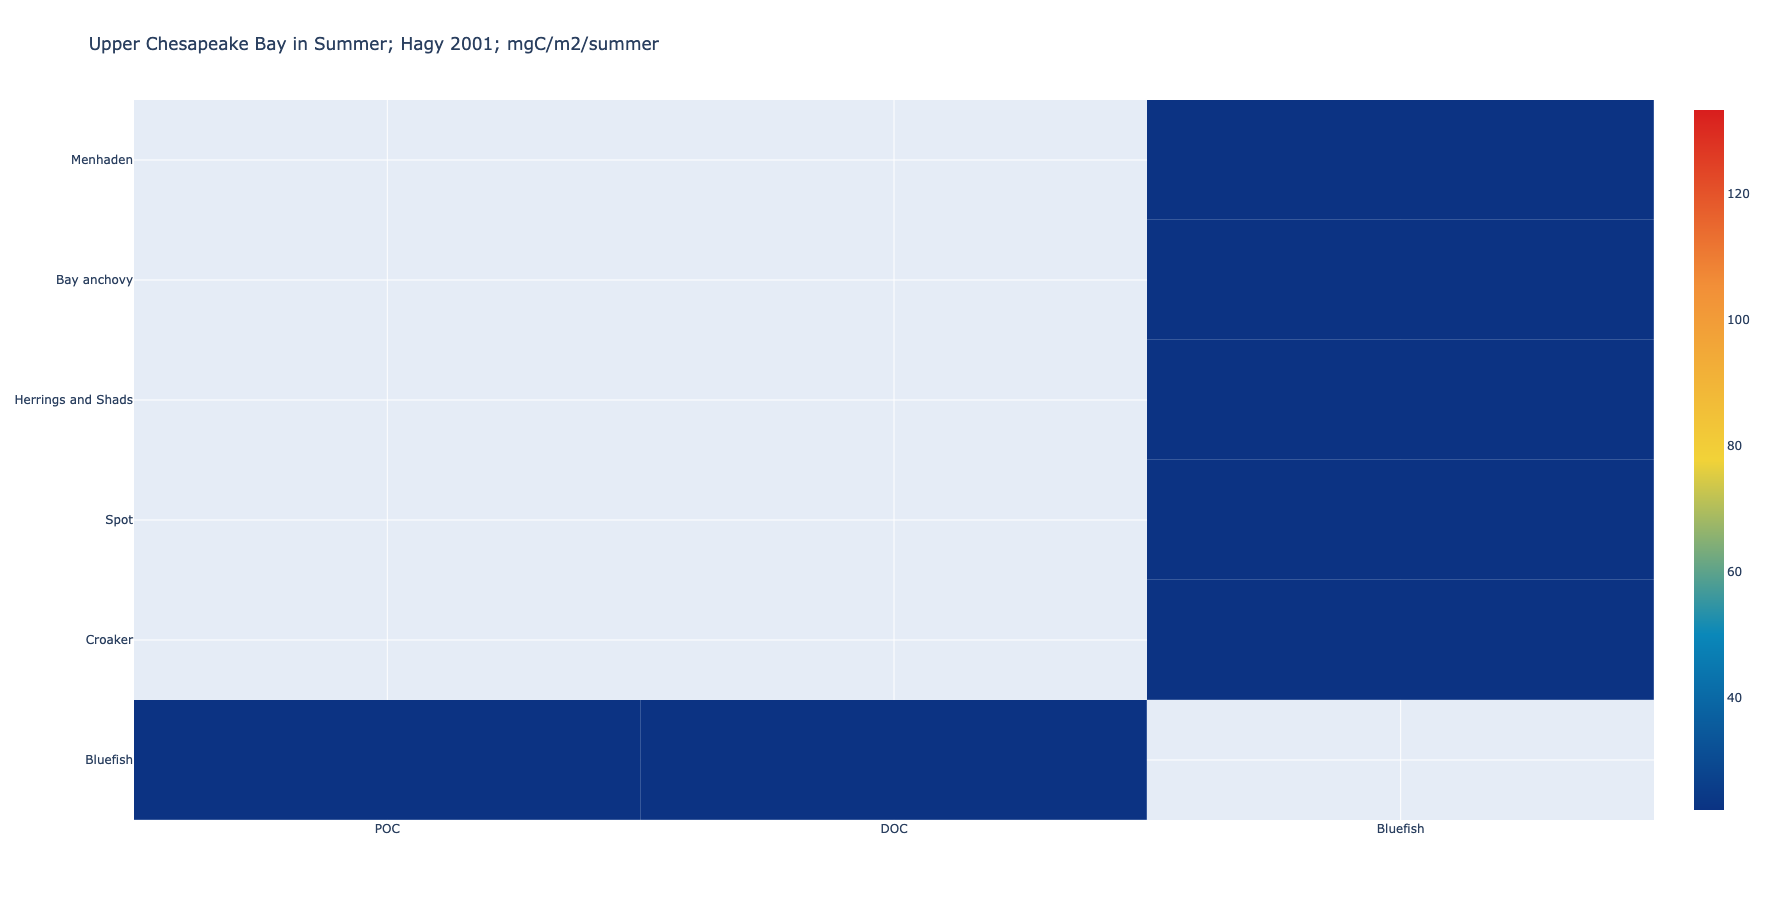

In [516]:
heat_for_name(food_webs[0], ['Bluefish'], True, False)

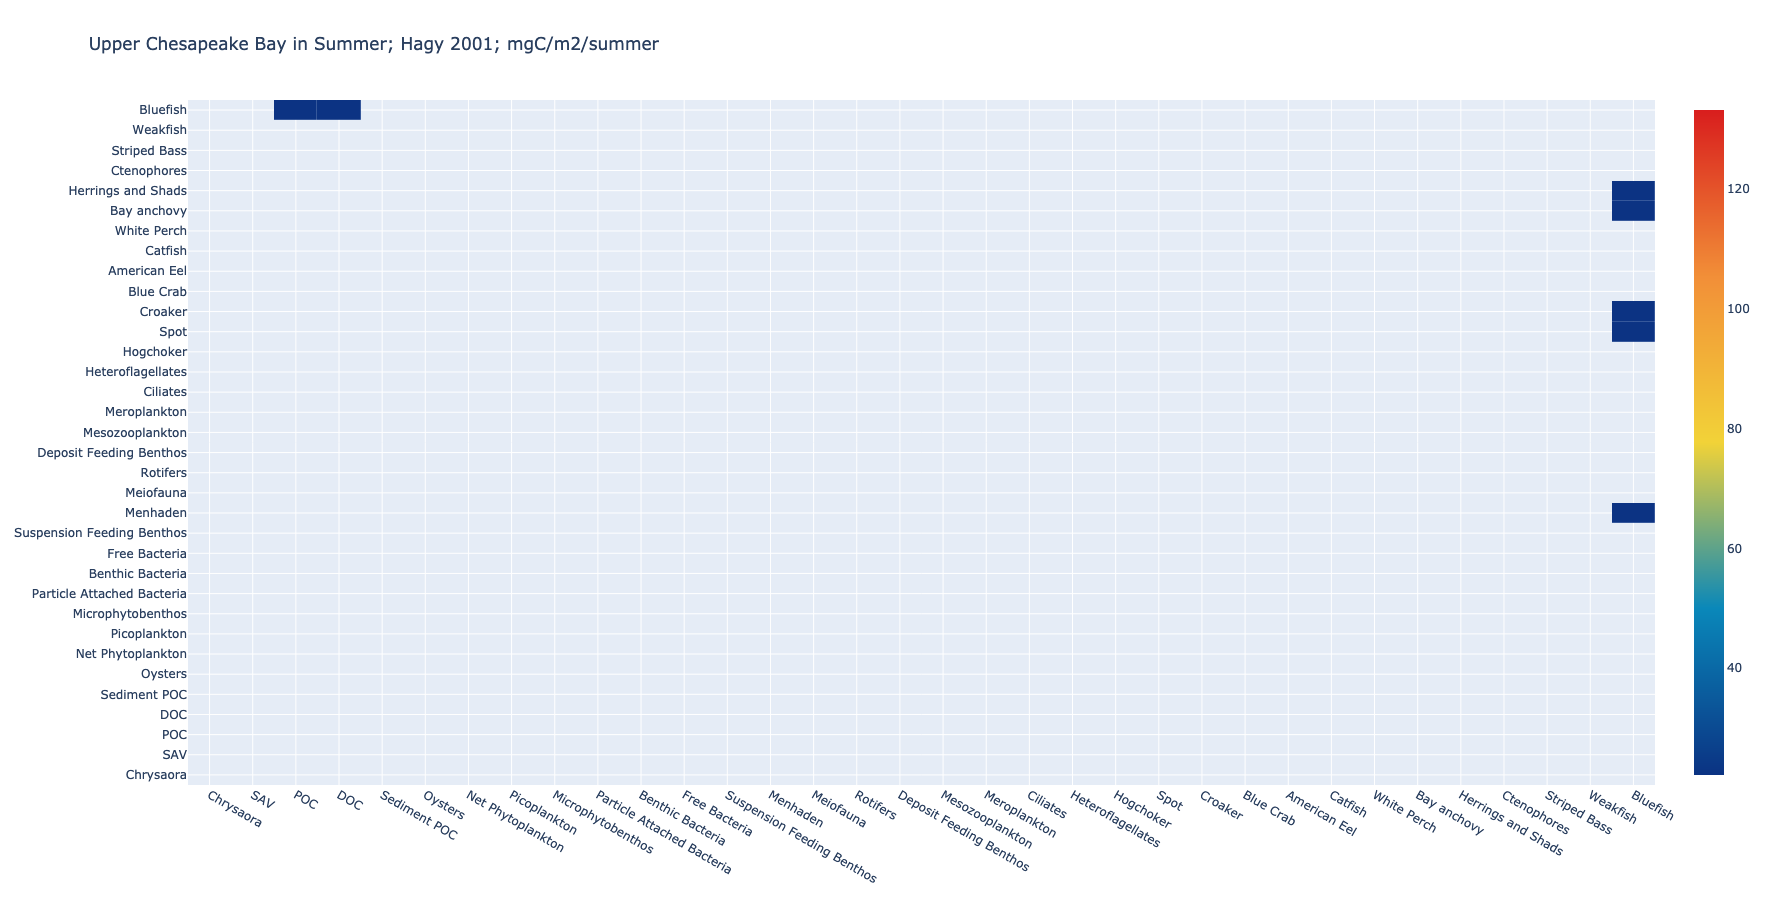

In [517]:
heat_for_name(food_webs[0], ['Bluefish'], True, True)

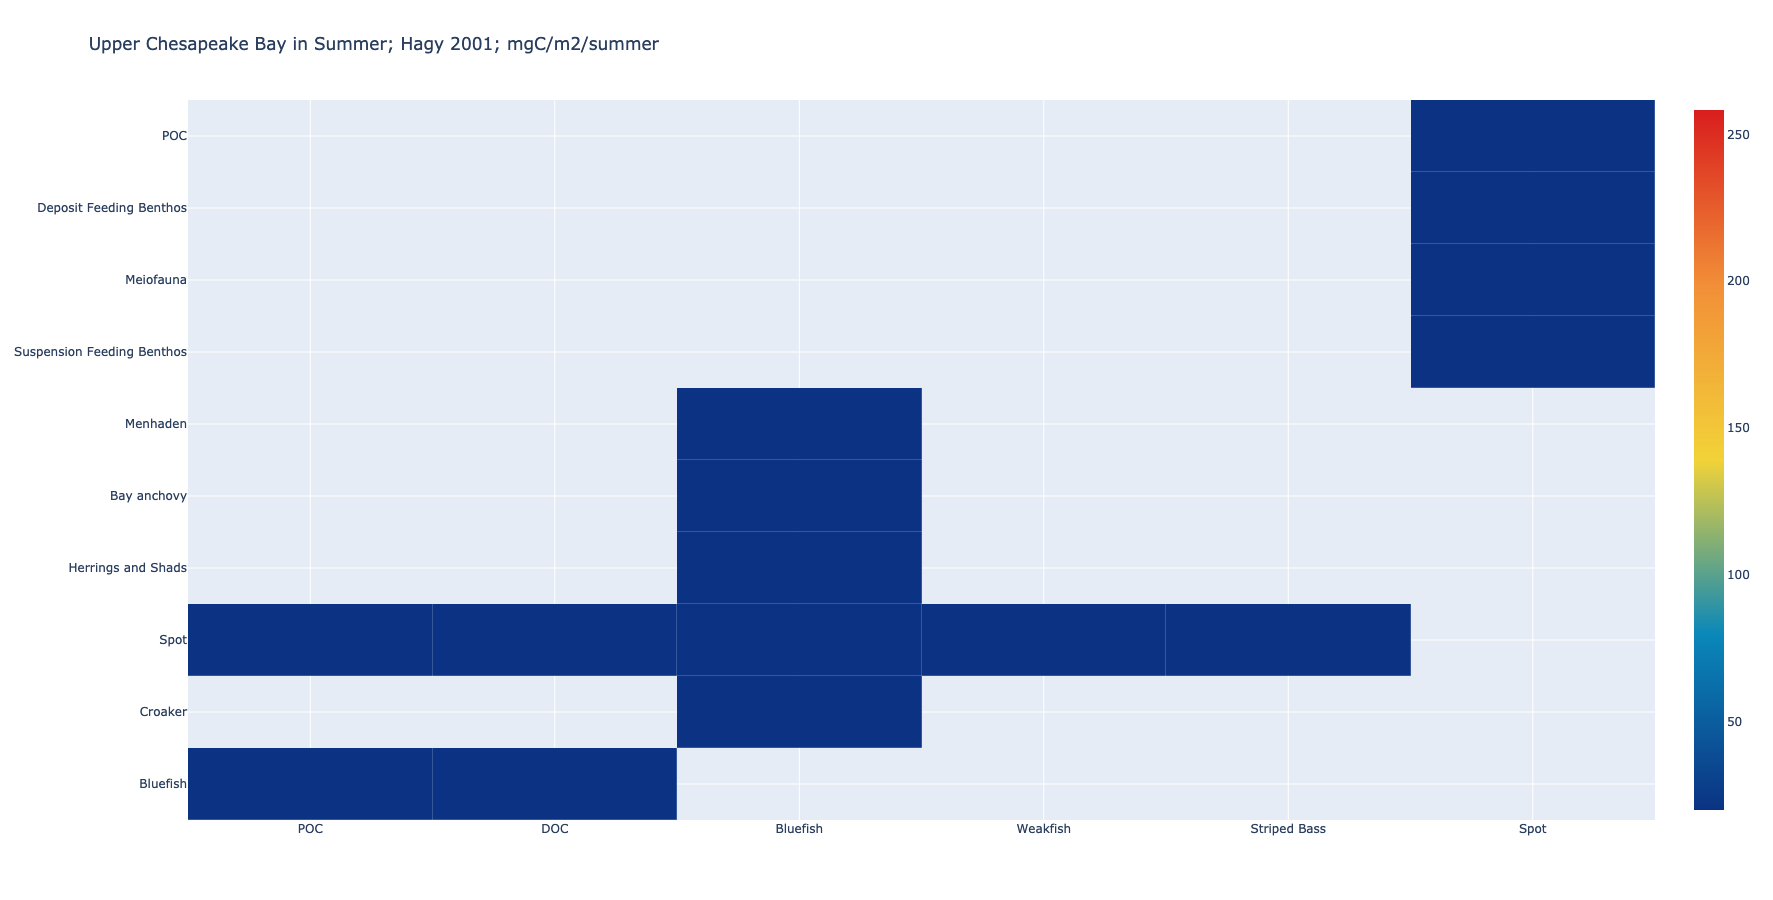

In [518]:
heat_for_name(food_webs[0], ['Bluefish', 'Spot'], True, False)

# dendogram?

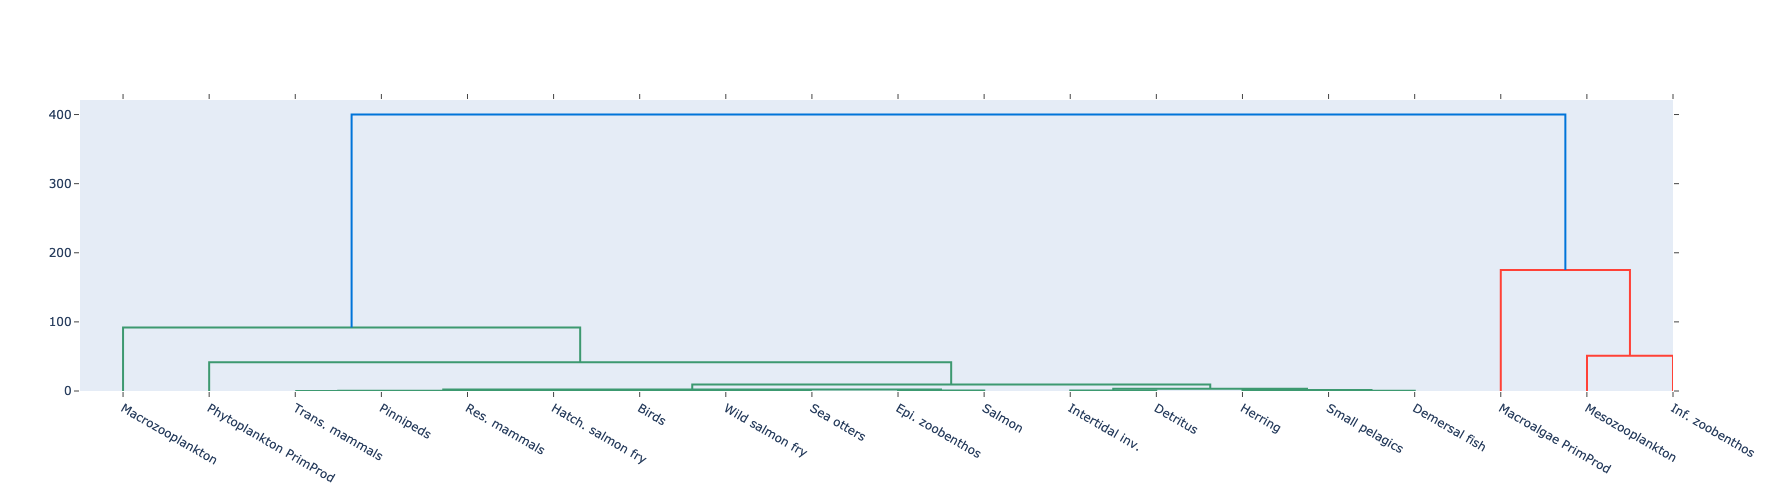

In [519]:
import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)

net = food_webs[5]

fig = ff.create_dendrogram(np.array([[x] for x in net.nodeDF.Biomass.values]), labels=net.nodeDF.Names.values)
fig.update_layout(width=800, height=500)
fig.show()

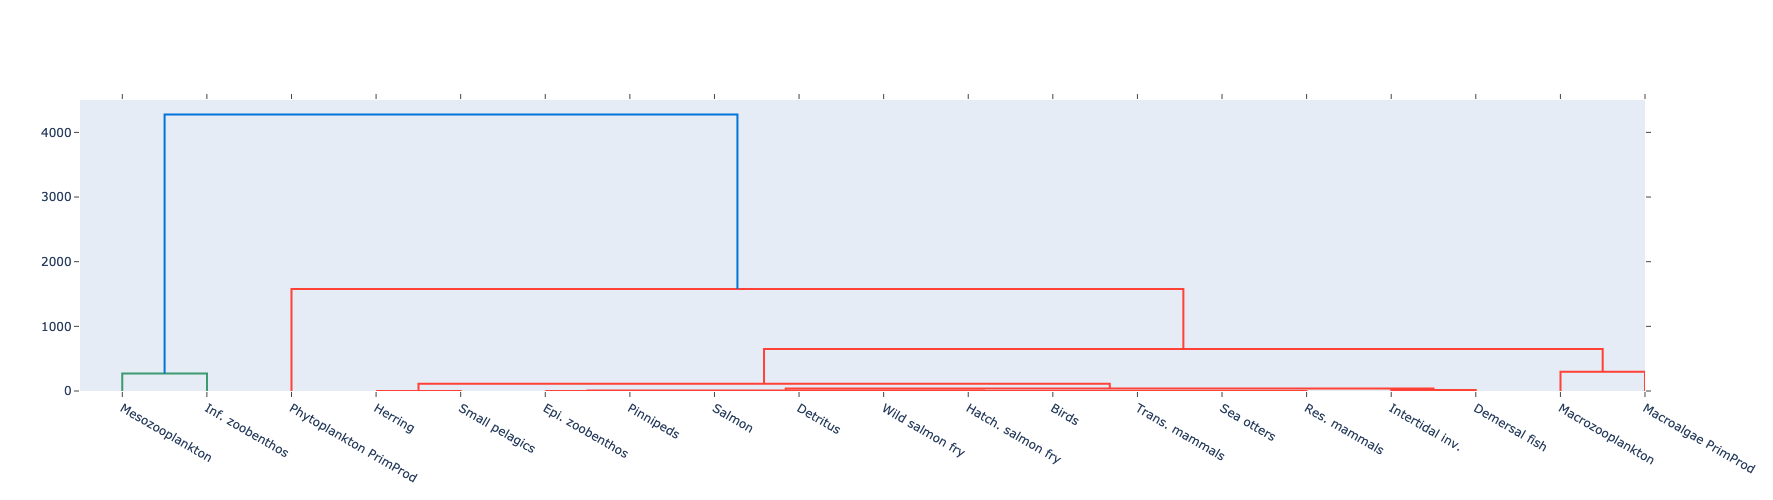

In [520]:
import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)

net = food_webs[5]

fig = ff.create_dendrogram(np.array([[x] for x in net.nodeDF.Respiration.values]), labels=net.nodeDF.Names.values)
fig.update_layout(width=800, height=500)
fig.show()

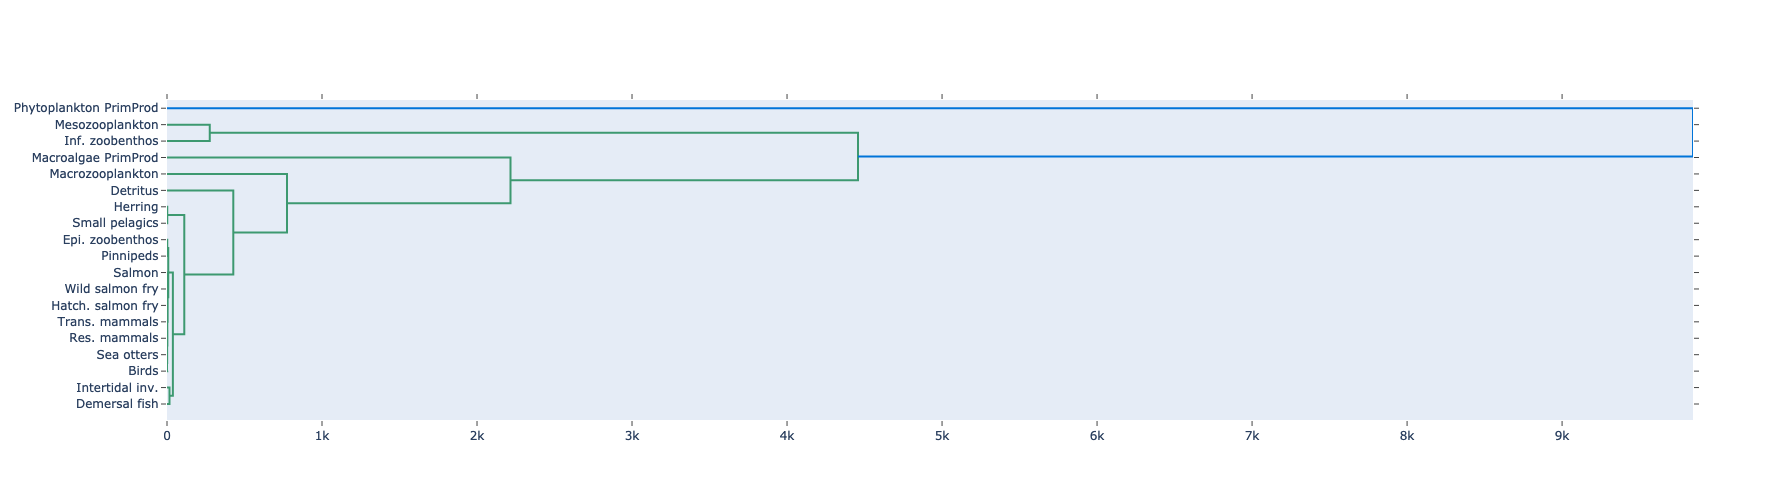

In [521]:
net = food_webs[5]

fig = ff.create_dendrogram(net.nodeDF[['Biomass', 'IsAlive', 'Import', 'Export', 'Respiration', 'TrophicLevel']].values, orientation='left', labels=net.nodeDF.Names.values)
fig.update_layout(width=1200, height=500)
fig.show()